# LSTM


In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 15:20:42.989605
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_total = 0
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            rci_total += rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        rci_avg = rci_total / rci_count
                        gene_to_rci[gene_id] = rci_avg
                        overall_sum += rci_avg
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 15:21:09.277413
Load RCI values...
Number of RCI values 13512
Mean RCI value -0.21695816698053308
Num RCI: 13512
Example RCI: [('ENSG00000000003', 1.2135481000000001), ('ENSG00000000419', 1.0423718181818182), ('ENSG00000000457', -0.6934341818181818)]
Load genes...
2023-01-17 15:21:10.103963
Load sequence...
2023-01-17 15:21:20.938822
Num IDs: 13675
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 7202 ones out of 13675 labels.
Num labels: 13675
Example labels: [0, 0, 0, 0]
Num sequences: 13675
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130,

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 15:21:20.972412
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1997, 4)           1028      
                                                                 
 bidirectional (Bidirectiona  (None, 1997, 64)         9472      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1997, 16)         1040      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 31952)             0         
                                                                 
 dropout (Dropout)           (None, 31952)             0         
                                                                 
 dense_1 (Dense)     

## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 15:21:24.287321
2023-01-17 15:21:24.289822
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10877, 1997) (10877, 1)
Valid sizes (2798, 1997) (2798, 1)
Train set ones/size 5642 / 10877
Valid set ones/size 1560 / 2798
BUILD MODEL
COMPILE
FIT
2023-01-17 15:21:26.440364
Epoch 1/3
340/340 [==============================] - 49s 118ms/step - loss: 0.6690 - accuracy: 0.5867 - val_loss: 0.6576 - val_accuracy: 0.6083
Epoch 2/3
340/340 [==============================] - 41s 120ms/step - loss: 0.6433 - accuracy: 0.6279 - val_loss: 0.6631 - val_accuracy: 0.6001
Epoch 3/3
340/340 [==============================] - 40s 117ms/step - loss: 0.6158 - accuracy: 0.6633 - val_loss: 0.6701 - val_accuracy: 0.6036


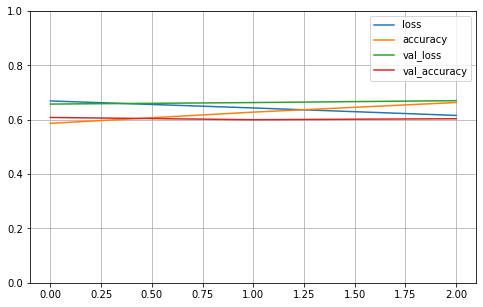

Compute valiation accuracy
2023-01-17 15:23:35.865583
Range of scores: 0.0664557 to 0.9213137
Predicted zeros and ones 1035 1763
Accuracy: 60.36% Precision: 62.79% Recall: 70.96% F1: 66.63%
2023-01-17 15:23:41.713877
Fold 2
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10965, 1997) (10965, 1)
Valid sizes (2710, 1997) (2710, 1)
Train set ones/size 5760 / 10965
Valid set ones/size 1442 / 2710
BUILD MODEL
COMPILE
FIT
2023-01-17 15:23:43.827389
Epoch 1/3
343/343 [==============================] - 45s 122ms/step - loss: 0.6686 - accuracy: 0.5859 - val_loss: 0.6577 - val_accuracy: 0.6114
Epoch 2/3
343/343 [==============================] - 40s 115ms/step - loss: 0.6481 - accuracy: 0.6243 - val_loss: 0.6608 - val_accuracy: 0.6048
Epoch 3/3
343/343 [==============================] - 40s 116ms/step - loss: 0.6254 - accuracy: 0.6522 - val_loss: 0.6799 - val_accuracy: 0.5982


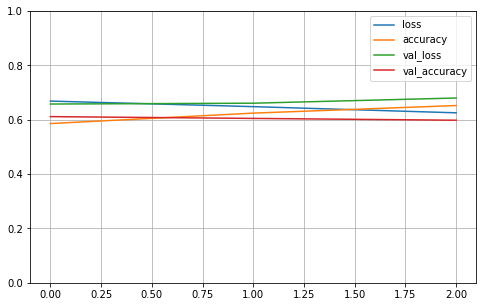

Compute valiation accuracy
2023-01-17 15:25:48.361837
Range of scores: 0.0422791 to 0.96365756
Predicted zeros and ones 953 1757
Accuracy: 59.82% Precision: 60.05% Recall: 73.16% F1: 65.96%
2023-01-17 15:25:54.628060
Fold 3
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10977, 1997) (10977, 1)
Valid sizes (2698, 1997) (2698, 1)
Train set ones/size 5830 / 10977
Valid set ones/size 1372 / 2698
BUILD MODEL
COMPILE
FIT
2023-01-17 15:25:56.727652
Epoch 1/3
344/344 [==============================] - 44s 118ms/step - loss: 0.6687 - accuracy: 0.5867 - val_loss: 0.6604 - val_accuracy: 0.5938
Epoch 2/3
344/344 [==============================] - 40s 117ms/step - loss: 0.6413 - accuracy: 0.6338 - val_loss: 0.6930 - val_accuracy: 0.5715
Epoch 3/3
344/344 [==============================] - 40s 117ms/step - loss: 0.6160 - accuracy: 0.6563 - val_loss: 0.6862 - val_accuracy: 0.5734


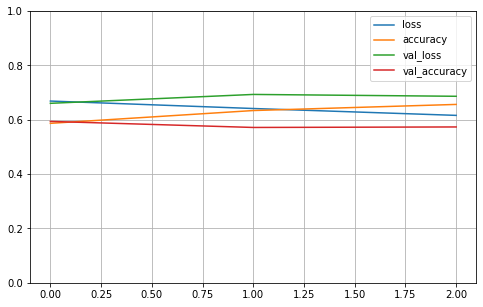

Compute valiation accuracy
2023-01-17 15:28:21.687495
Range of scores: 0.053315144 to 0.95754397
Predicted zeros and ones 1071 1627
Accuracy: 57.34% Precision: 56.79% Recall: 67.35% F1: 61.62%
2023-01-17 15:28:27.495304
Fold 4
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10875, 1997) (10875, 1)
Valid sizes (2800, 1997) (2800, 1)
Train set ones/size 5762 / 10875
Valid set ones/size 1440 / 2800
BUILD MODEL
COMPILE
FIT
2023-01-17 15:28:29.577161
Epoch 1/3
340/340 [==============================] - 44s 120ms/step - loss: 0.6659 - accuracy: 0.5912 - val_loss: 0.6587 - val_accuracy: 0.6032
Epoch 2/3
340/340 [==============================] - 40s 117ms/step - loss: 0.6428 - accuracy: 0.6344 - val_loss: 0.6784 - val_accuracy: 0.5679
Epoch 3/3
340/340 [==============================] - 41s 120ms/step - loss: 0.6242 - accuracy: 0.6548 - val_loss: 0.6959 - val_accuracy: 0.5725


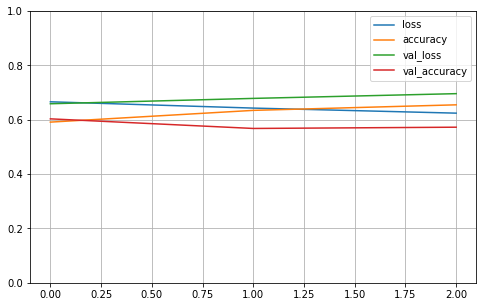

Compute valiation accuracy
2023-01-17 15:30:55.046145
Range of scores: 0.07361282 to 0.9479735
Predicted zeros and ones 735 2065
Accuracy: 57.25% Precision: 55.88% Recall: 80.14% F1: 65.85%
2023-01-17 15:31:00.047796
Fold 5
Training example
[187 235 170 ...   0   0   0]
Train sizes (11006, 1997) (11006, 1)
Valid sizes (2669, 1997) (2669, 1)
Train set ones/size 5814 / 11006
Valid set ones/size 1388 / 2669
BUILD MODEL
COMPILE
FIT
2023-01-17 15:31:02.099210
Epoch 1/3
344/344 [==============================] - 44s 119ms/step - loss: 0.6687 - accuracy: 0.5829 - val_loss: 0.6619 - val_accuracy: 0.5969
Epoch 2/3
344/344 [==============================] - 40s 117ms/step - loss: 0.6418 - accuracy: 0.6327 - val_loss: 0.6684 - val_accuracy: 0.5920
Epoch 3/3
344/344 [==============================] - 41s 118ms/step - loss: 0.6206 - accuracy: 0.6570 - val_loss: 0.6745 - val_accuracy: 0.5912


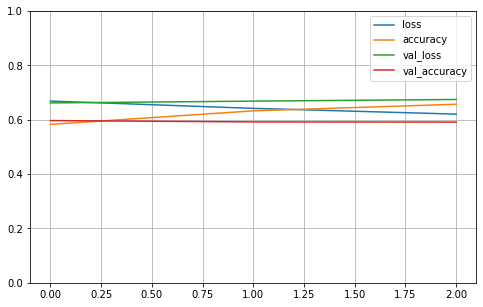

Compute valiation accuracy
2023-01-17 15:33:27.138244
Range of scores: 0.0705598 to 0.92675865
Predicted zeros and ones 1056 1613
Accuracy: 59.12% Precision: 59.21% Recall: 68.80% F1: 63.65%
2023-01-17 15:33:32.926831

Cross validation 5 folds 3 epochs
 accuracy mean 58.78% +/- 1.27
 precision mean 58.94% +/- 2.45
 recall mean 72.08% +/- 4.48
 F1 mean 64.74% +/- 1.85
2023-01-17 15:33:32.929338


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())